# Facebook Recruiting IV: Human or Robot? _[Kaggle competition](https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot)_

## Is the bid made by Human or by Robot?

## Background

Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.

In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, including bid frequency over short periods of time, has proven insufficient. 

The goal of this project is to identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity. 

## Known issues

1. bid frequency over short periods of time has proven insufficient
2. The outcome was half hand labeled, half stats-based. There are two types of "bots" with different levels of proof:
   * Bidders who are identified as bots/fraudulent with clear proof. Their accounts were banned by the auction site.
   * Bidder who may have just started their business/clicks or their stats exceed from system wide average. There are no clear proof that they are bots. 

## Questions to be explored:

1. What are the behavioral differences/similarities between human and robot bidders? 
2. Does concept of "outliers" make sense in this senario?
3. Which countries have more robots bidders? 
4. Which devices people prefer to run bid-software?
5. Which merchandises do robot bidders prefer?
6. Can the two types of 'bots' be distinguished?

In [49]:
#load all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import pycountry
import itertools

%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [2]:
#load and view data
data = pd.read_csv('Data/bids.csv')
data.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [62]:
#define functions for convinience
#----------------------------------#
#- Function name: categorising    -#
#- Usage: to convert string       -#
#-        features to categorical -#
#-        features and represent  -#
#-        data by their codes     -#
#- Arguments:                     -#
#-      data: dataset for analysis-#
#-    column1-3: columns to be    -#
#-               converted        -#
#----------------------------------#
def categorising(data, column1, column2, column3):
    data[column1] = data[column1].astype('category')
    data[column2] = data[column2].astype('category')
    data[column3] = data[column3].astype('category')
    cat_columns = data.select_dtypes(['category']).columns
    #represent data by their codes
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
#------------------------------------#
#- Function name: mergedata         -#
#- Usage: to merge two data sets    -#
#-        on their common columns   -#
#- Arguments:                       -#
#-      data: dataset for analysis  -#
#-    bidder: selected bidder for   -#
#-            further analysis,     -#
#-            the bidders are almost-#
#-            randomly selected     -#
#------------------------------------#
def mergedata(data, bidder):
    mer_bidder = data.merge(bidder, left_on = 'bidder_id', right_on = 'bidder_id', how = 'left')
    return mer_bidder[mer_bidder.payment_account.notnull()]
#-----------------------------------#
#- Function name: scatter_plot     -#
#- Usage: to build scatter plots   -#
#-        on bid_id and time       -#
#- Arguments:                      -#
#-    auctions: code of auctions   -#
#-      data: dataset for analysis -#
#-      ncol: number of columns for-#
#-            the subplots         -#
#-      nrow: number of rows for   -#
#-            the subplots         -#
#-----------------------------------#
def scatter_plot(auctions, data, ncol, nrow):
    #set up figure size and subplots
    fig, axs = plt.subplots(ncols = ncol, nrows = nrow, figsize = (12, 15), sharex =True, sharey=True)
    i = 0
    for auction in auctions.index:
        df = data[data['auction'] == auction]
        sns.regplot(x = 'bid_id', y = 'time', data = df, ax = axs[i], fit_reg=False)
        axs[i].set_title('auction: {}'.format(auction))
        i += 1
    fig.tight_layout()
#----------------------------------#
#- Function name: conv_bar_plot   -#
#- Usage: to convert string values-#
#-        to numericals ones and  -#
#-        build a bar plot        -#
#- Arguments:                     -#
#-      data: dataset for analysis-#
#-    column: the column used for -#
#-            build bar plot      -#
#----------------------------------#
def conv_bar_plot(data, column):
    #change string values to numerical ones.
    mer_cates = data[column].unique()
    num_cates = range(len(mer_cates))
    train_bid.replace(mer_cates, num_cates, inplace = True)
    _ = sns.barplot(data=data, x=column, y='outcome')
    _ = plt.ylabel('percentage labeled as robots')
    _ = plt.title('which {} do robot bidders prefer?'.format(column))
#--------------------------------------#
#- Function name: bids_per_auction    -#
#- Usage: to build histogram of       -#
#-        number of bids that a       -#
#-        bidder made per auction     -#
#- Arguments:                         -#
#-      data: dataset for analysis    -#
#-  columns1: contain two columns     -#
#-            one used for groupby;   -#
#-            the other as denominator-#
#-  columns2: contain two columns     -#
#-            one used for groupby;   -#
#-            the other as numerator  -#
#--------------------------------------#
def bids_per_auction(data, columns1=[], columns2=[]):
    bots_num_auction = pd.DataFrame(data[data['outcome'] == 1][columns1]\
                       .groupby(columns1[0])[columns1[1]].nunique())
    bots_num_bids = data[data['outcome'] == 1][columns2].groupby(columns2[0]).count()
    bots_avg = pd.DataFrame(bots_num_bids[columns2[1]]/bots_num_auction[columns1[1]])
    bots_avg = bots_avg.rename(columns = {0:'average bids per auction'})
    fig, axses = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 5), sharex =False, sharey=False)
    _ = sns.distplot(bots_avg['average bids per auction'],
                     hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True), ax = axses[0])
    _ = axses[0].set_ylabel('frequency')
    _ = axses[0].set_xlabel('number of bids per auction per bidder')
    _ = axses[0].set_title('How many bids does a ROBOT bidder made averagely per auction')
    human_num_auction = pd.DataFrame(data[data['outcome'] == 0][columns1]\
                       .groupby(columns1[0])[columns1[1]].nunique())
    human_num_bids = data[data['outcome'] == 0][columns2].groupby(columns2[0]).count()
    human_avg = pd.DataFrame(human_num_bids[columns2[1]]/human_num_auction[columns1[1]])
    human_avg = human_avg.rename(columns = {0:'average bids per auction'})
    _ = sns.distplot(human_avg.drop('916d2d806b772c9f227a9b3640e31469ljrxo')['average bids per auction'],
                     hist_kws=dict(cumulative=True),
                     kde_kws=dict(cumulative=True), ax = axses[1])
    _ = axses[1].set_ylabel('frequency')
    _ = axses[1].set_xlabel('number of bids per auction per bidder')
    _ = axses[1].set_title('How many bids does a HUMAN bidder made averagely per auction')
#-----------------------------------#
#- Function name: dist_most        -#
#- Usage: to visualize proportion  -#
#-        of bots bidders for      -#
#-        categorical variables    -#
#- Arguments:                      -#
#-      data: the dataset used     -#
#-            used for analysis    -#
#-      column: the variable to be -#
#-              visualized         -#
#-----------------------------------#
def dist_most(data, column):
    grouped_cols = pd.DataFrame(data.groupby('outcome')[column].value_counts()).\
                             rename(columns={column:'number_of_bidders'}).reset_index()
    grouped_cols_bots = grouped_cols[grouped_cols.outcome == 1]
    grouped_cols_human = grouped_cols[grouped_cols.outcome == 0]
    merged = grouped_cols_human.merge(grouped_cols_bots, left_on = column, right_on = column, how = 'left')
    merged['proportion'] = merged.number_of_bidders_y/(merged.number_of_bidders_y + merged.number_of_bidders_x)
    merged_grouped = merged.sort('proportion').dropna()
    merged_grouped = merged_grouped[(merged_grouped['number_of_bidders_x']\
                                        +merged_grouped['number_of_bidders_y'])>= 500]
    merged_grouped.rename(columns={'number_of_bidders_x': 'num_human_bidders', 
                                   'number_of_bidders_y':'num_bots_bidders'}, inplace = True)
    display(merged_grouped.tail(10))
    _ = sns.distplot(merged_grouped.proportion, bins = 20, kde=False, rug=False)
    _ = plt.xlabel("proportion of robot bidders")
    _ = plt.ylabel('frequency')
    _ = plt.title('proportion of robot bidders by {}'.format(column))
    fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5), sharex =False, sharey=False)
    plot_data = merged_grouped[[column, 'proportion']].set_index(column).tail(10)
    _ = plot_data.plot(kind='bar', ax = axes[0])
    _ = axes[0].set_ylabel('proportion')
    _ = axes[0].set_title('Top 10 {} with largest percent of robot bidders'.format(column))
    plot_data = merged_grouped[[column, 'proportion']].set_index(column).head(10)
    _ = plot_data.plot(kind='bar', ax = axes[1])
    _ = axes[1].set_ylabel('proportion')
    _ = axes[1].set_title('Top 10 {} with smallest percent of robot bidders'.format(column))
    plt.tight_layout()
    
    return merged_grouped
#-----------------------------------#
#- Function name: dist_most        -#
#- Usage: to visualize proportion  -#
#-        of bots bidders for      -#
#-        categorical variables    -#
#- Arguments:                      -#
#-      data: the dataset used     -#
#-            used for analysis    -#
#-      column: the variable to be -#
#-              visualized         -#
#-----------------------------------#
def draw_map(data):
    countries = pd.DataFrame(data.country.apply(lambda x: x.upper()))
    country_dict = {}
    for country_code in countries.country:
        for country in pycountry.countries:
            if country_code == country.alpha_2:
                country_dict[country_code] = country.name
    
    df = pd.DataFrame.from_dict(country_dict, orient='index').reset_index().\
                  rename(columns={'index':'country_code', 0:'country_name'})
    
    pro_country = grouped[['proportion', 'country']]
    pro_country.country = pro_country.country.apply(lambda x: x.upper())
    code_name_pro = pro_country.merge(df, left_on='country', right_on='country_code', how = 'left').drop('country', axis=1)
    
    
    
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
    lst = list(code_name_pro.proportion)

    minima = min(lst)
    maxima = max(lst)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.CMRmap_r)
    rgb_lst = []
    for v in lst:
        rgb_lst.append(list(mapper.to_rgba(v)))

    plt.figure(figsize=(12,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for country in shpreader.Reader(countries_shp).records():
        for i in range(len(code_name_pro.country_name)):
            if (country.attributes['name_long']) == code_name_pro.country_name[i]:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=rgb_lst[i],
                                  label=country.attributes['name_long'])
    plt.title("Robot bidders' distribution")
    mapper.set_array(lst)
    plt.colorbar(mapper, fraction=0.023, pad=0.04)

In [4]:
#Merge training data with bids data, because only training data has 'outcome' column, which will be used as labels
bidder_train = pd.read_csv('Data/train.csv')
train_bid = mergedata(data, bidder_train)
train_bid.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,a3d2de7675556553a5f08e4c88d2c228ucoac,42a3b61a1fe69d66ad60f3e347aa09b1erfe2,0.0
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,2c198811bf76f74512e24f5a537e21f9o3kyh,4e408da3d4dc783220f7d7c6a2f6bb62fxl68,0.0
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
10,10,a58ace8b671a7531c88814bc86b2a34cf0crb,z6j8b,sporting goods,phone10,9759243210526315,ng,209.80.85.101,adgjz71s3p2oiau,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
13,13,7e34a26c4c339e875997f4b9239d2b5fscng4,nbx39,mobile,phone13,9759243263157894,in,143.183.225.33,e5i17pk9wygxewv,d1154cf7f47d7be0579cf24f6df1edcaagi99,fe7698870c64030109477f0d692741bfb3jn2,0.0


## Proportion of human bidders and robot bidders

To see how severe the problem is, looking at the proportion of two types of bidders could be a good choice.

In [5]:
bot_bidder = train_bid[train_bid.outcome == 1]
print("Robot bidders: {0:.5g}%".format(len(bot_bidder)*100/len(train_bid)))

Robot bidders: 13.428%


In [6]:
human_bidder = train_bid[train_bid.outcome == 0]
print("Human bidders: {0:.5g}%".format(len(human_bidder)*100/len(train_bid)))

Human bidders: 86.572%


From above proportions, robot bidders would not be a big problem for online auctions.

But is that true?

Let's think about the same problem in another way:

In [7]:
robots = train_bid[train_bid.outcome == 1][['auction']]
human = train_bid[train_bid.outcome == 0][['auction']]
total = train_bid.auction.nunique()
robots_auction = robots.auction.nunique()
human_auction = human.auction.nunique()
print("Auctions which robot bidders participated in: {0:.5g}%".format(robots_auction*100/total))

Auctions which robot bidders participated in: 50.157%


Now we can see, although low proportion of robot bidders, they do make significant percent of bids which is more than half of the bids! This shows the problem is really severe that the online auction company must solve

## Behaviors of human and robot bidders

**1. Robot bidders:**

In [11]:
#select only robot bidders
bots_data = train_bid[(train_bid.merchandise == 'mobile') & (train_bid.outcome == 1)]
eg_bots_bidder = bots_data[bots_data.bidder_id == 'fae553f133602fba6e9e6051dfb27fefkruax']
eg_bots_bids = eg_bots_bidder.groupby('auction').count().sort('bid_id').tail(6)

						  merchandise: mobile
				    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3


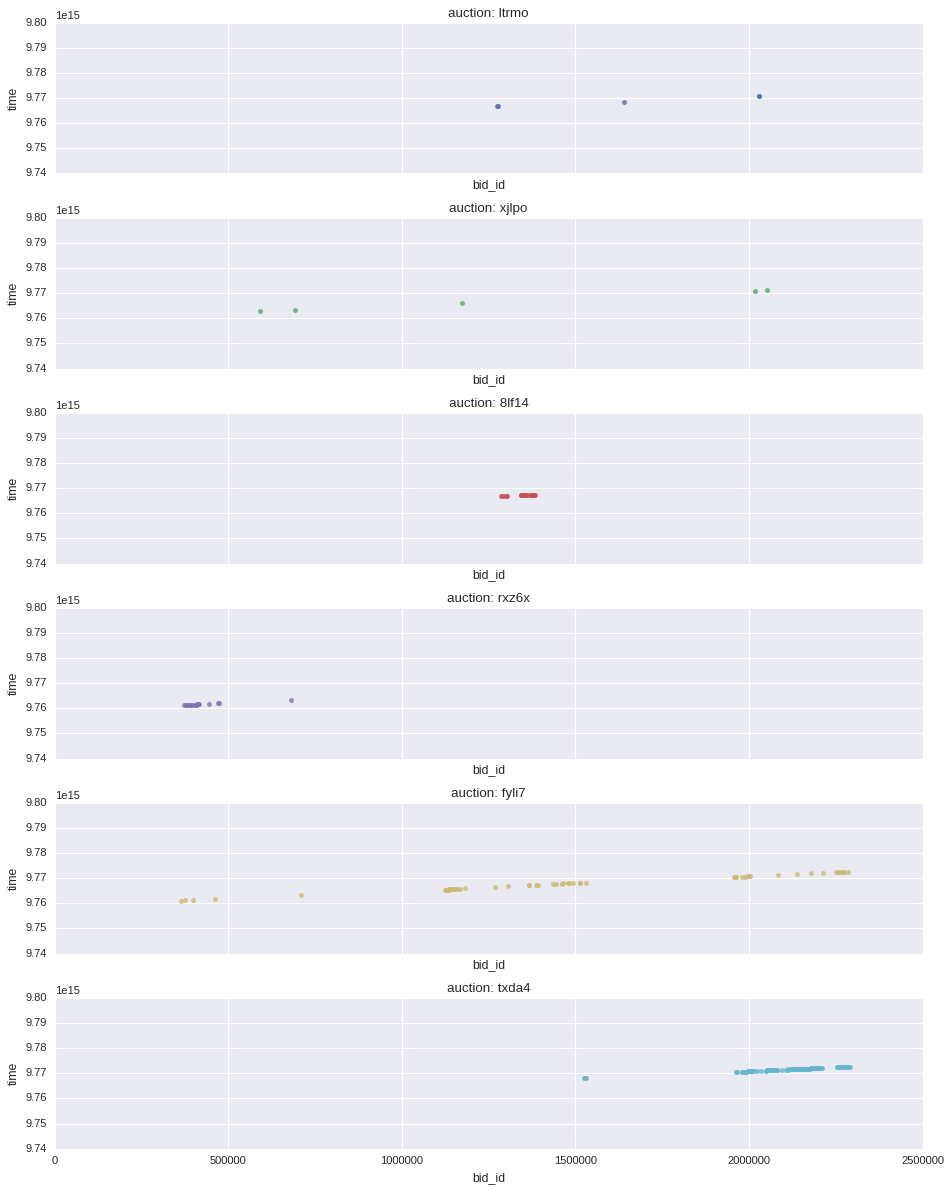

In [12]:
#plot all bids the bidder has made along with time the bids made
scatter_plot(eg_bots_bids, eg_bots_bidder, 1, 6)
print("\t\t\t\t\t\t  merchandise: mobile\n\t\t\t\t    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3")

**2. Human bidders:**

In [13]:
#select only human bidders
human_data = train_bid[(train_bid.merchandise == 'mobile') & (train_bid.outcome == 0)]
eg_human_bidder = human_data[human_data.bidder_id == 'ffc4e2dd2cc08249f299cab46ecbfacfobmr3']
eg_human_bids = eg_human_bidder.groupby('auction').count().sort('bid_id').tail(6)

						  merchandise: mobile
				    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3


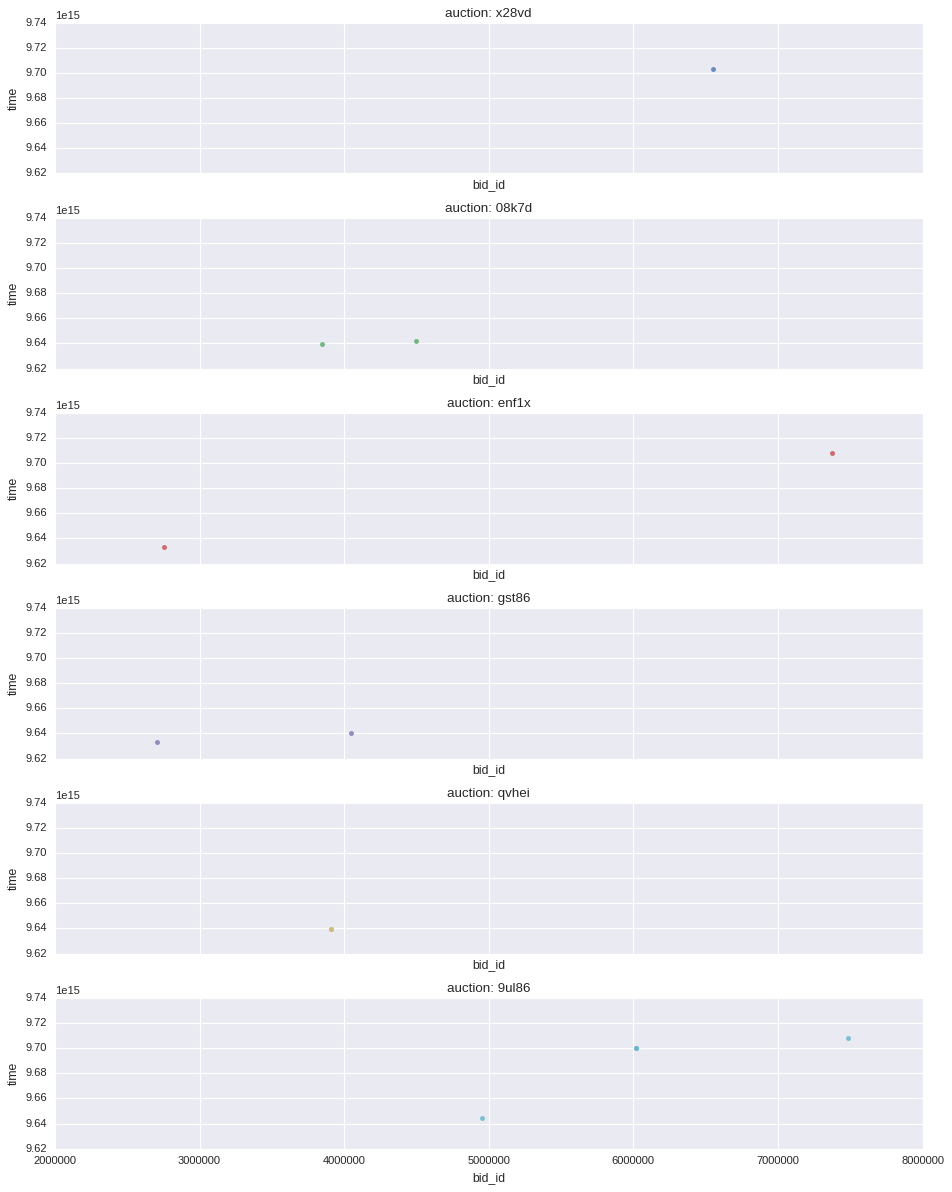

In [14]:
#plot all bids the bidder has made along with time the bids made
scatter_plot(eg_human_bids, eg_human_bidder, 1, 6)
print("\t\t\t\t\t\t  merchandise: mobile\n\t\t\t\t    bidder ID: ffc4e2dd2cc08249f299cab46ecbfacfobmr3")

It is clear that robot bidders usually make series bids in a short period of time. And for this robot bidder, it only make bids in a fixed time interval(which is 9.6--9.8). While for the human bidder, the distribution of bids he made seems more random and cannot find a specific pattern among all the auctions he participated in.

Since the above graphs are from only two bidders, it's too early to make any conclusions, but it can still provide some valuable insights before moving on.

## Which merchandise do robot bidders prefer?

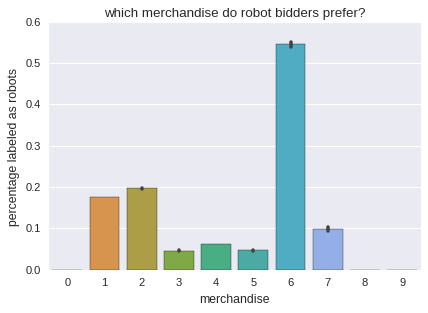

In [15]:
conv_bar_plot(train_bid, 'merchandise')

### Before we talk about this graph, let's take a look at what the numbers stand for

| 	merchandise  |  cate_numbers |
|:--------------:|:-------------:|
|furniture       |	     0       |
|mobile          |       1       |
|sporting goods  |       2       |
|home goods	     |       3       |
|jewelry	     |       4       |
|office equipment|    	 5       |
|computers	     |       6       |
|books and music |       7       |
|auto parts 	 |       8       |
|clothing        |       9       |

Robot bidders are more likely to make bids for computers, mobile and furniture. But they are not interested in auto parts and clothing. Although the reason behind could be complicated, the owner of the website do need to pay more attention on computers, mobile and furniture.

### How many bids does a ROBOT/HUMAN bidder made averagely per auction? 

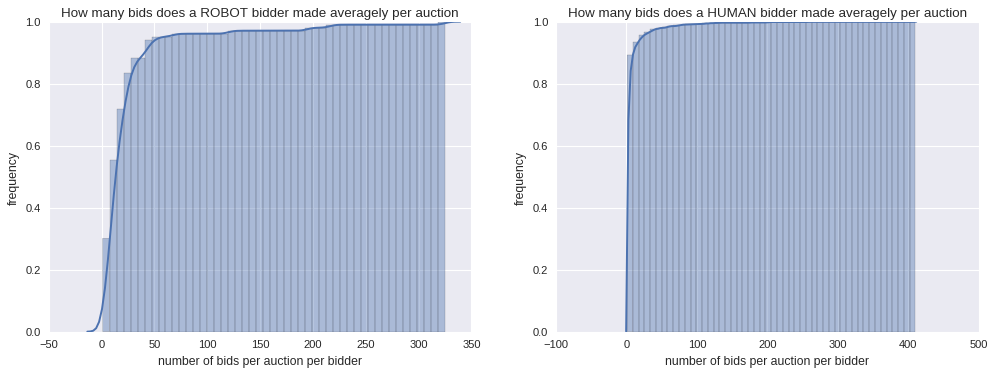

In [16]:
bids_per_auction(train_bid, columns1=['bidder_id', 'auction'], columns2=['bidder_id', 'bid_id'])

From above plots, more than 90% of robot bidders make 50 or less bids while more than 90% of human bidders make 20 or less bids. 

One important finding is that number of bids cannot be used to classify whether a bidders is human or robot, because there are also some human bidders make many bids. But one thing noticable is most robot bidders making more bids than most human bidders. This indicates although number of bids cannot be used to classify bidder types directly, it still can be used as a minor feature.

### Number of human/bots bidders for different countries

	Top 10 countries that has highest percentage of bots bidders


,outcome_x,country,num_human_bidders,outcome_y,num_bots_bidders,proportion
70,0.0,se,2790,1.0,2479.0,0.470488
77,0.0,il,2397,1.0,2138.0,0.471444
9,0.0,us,73380,1.0,66663.0,0.476018
99,0.0,tw,1329,1.0,1285.0,0.491584
43,0.0,au,7756,1.0,8634.0,0.526785
42,0.0,ca,7804,1.0,9205.0,0.541184
76,0.0,at,2445,1.0,3407.0,0.582194
35,0.0,de,10436,1.0,18530.0,0.639716
116,0.0,kr,634,1.0,6340.0,0.909091
125,0.0,jp,498,1.0,7921.0,0.940848


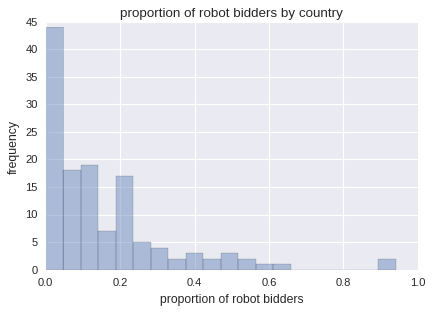

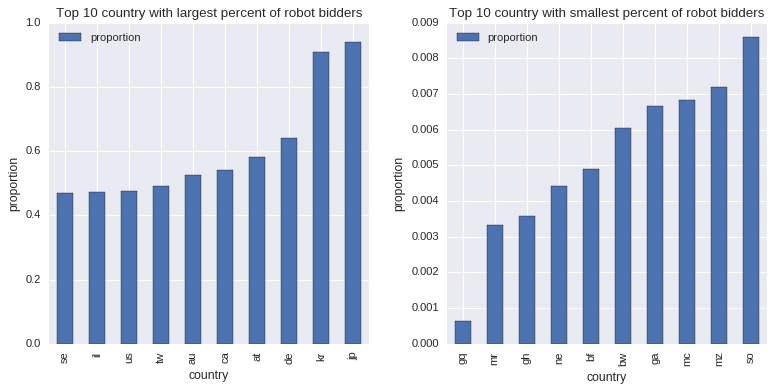

In [12]:
print('\tTop 10 countries that has highest percentage of bots bidders')
grouped = dist_most(train_bid, 'country')

### A map may be helpful to see the results:

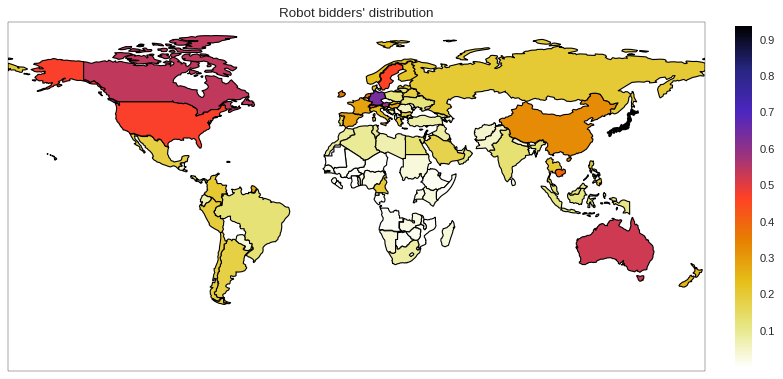

In [63]:
#print("Robot bidders' distribution")
draw_map(grouped)

#### Note: Countries with white color may indicate they have very low percentage of bots bidders, but it also could be lack of data for certain countries (We only have 130 countries' data while there are 195 countries around the world)

This part could be the most interesting finding in this project.

But before we move on, one thing I want to let you know that I have dropped countries who has less than 500 bid records. 
These countries will not provide valuable information because of their sample sizes.

From above table and plots, most countries do not have too many robot bidders(less than 10%). While other countries have significantly more amount of robot bidders. It is also surprising that U.S., Australia, Canada, Germany, Taiwan, Korea, Japan, Sweden, Austria, Israel has really large percent of robot bidders, expecially Japan and korea(more than 90% robot bidders). Since they are all deveploped regions, people in these countries may be more experienced in programming/softwar developing, which could result in large number of robot bidders. To prove this view, let's look at the third plot -- 10 countries with smallest percentage of robot bidders, are undeveloped and small countries, like Equatorial Guinea, Mauritania, Niger, etc. Therefore, 'country' could be a good estimator for classifying bidders' types.

### Number of human/bots bidders for different devices

	Top 10 devices that has highest percentage of bots bidders


,outcome_x,device,num_human_bidders,outcome_y,num_bots_bidders,proportion
677,0.0,phone466,209,1.0,2334.0,0.917814
1329,0.0,phone491,49,1.0,560.0,0.919540
968,0.0,phone322,99,1.0,1189.0,0.923137
1041,0.0,phone488,83,1.0,997.0,0.923148
1096,0.0,phone902,73,1.0,1058.0,0.935455
1378,0.0,phone398,44,1.0,681.0,0.939310
1390,0.0,phone559,43,1.0,712.0,0.943046
1046,0.0,phone796,82,1.0,1516.0,0.948686
1627,0.0,phone2287,29,1.0,933.0,0.969854
3096,0.0,phone883,5,1.0,549.0,0.990975


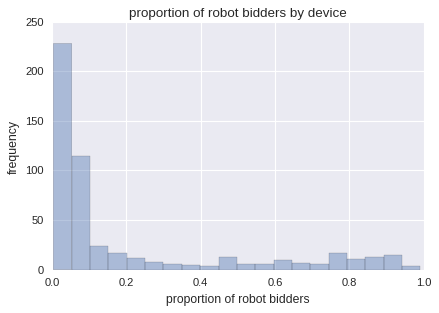

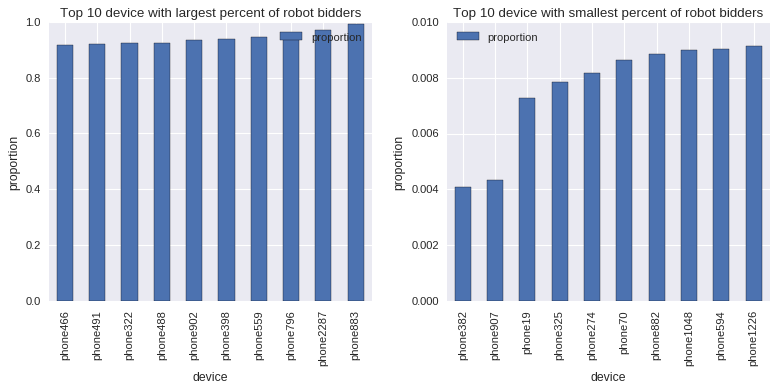

In [18]:
print('\tTop 10 devices that has highest percentage of bots bidders')
dist_most(train_bid, 'device')

Some models are preffered to running bidding software while others are merely used for this. Since the exact phone models are not available in this dataset, we are not able to explore more based on their brands and models. However, the result shows model of phones do have realationship with bidders' type.

Because of lack of models information in this project, it is not possible to make further analysis at this time. But if I google "auction sniping tools for ios/Android", these softwares do not require latest version of oprating system, which will make it easier to install and set up robot bidders on most cell phone. So model and brand information would be helpful for further analysis.

## Further findings

If you google "bidder robot" (actually they have another name "Auction Sniper"), the result would be astonishing. Although in this project auction snipers will be removing from their site to prevent unfair auction activity, the google results show many companies are now selling auction sniper online to help people make bids. If you look at those software, you can even set up your own strategy to avoid classifying as robot bidders. For example, you can tell the robot which item and auction to bid on, who your friends are, what price range you can accept. You can standardized their behavior to make it like human bidders. I also have experience making bids online (e.g. eBay). I know that kind of feeling when your bids are 'stolen' by others at the last 5 seconds. It is really unfair for humans to make bids against robots. 

Some auction sites (such as iGavel, the New Zealand auction site TradeMe, and the real estate auction site Bid on the City) automatically extend the bid deadline by a few minutes if a bid is placed in the last moments of the auction, to give other buyers time to react.